<font color='blue'> **14_LAK** </font> 

In [1]:
from modflow_devtools.misc import get_env;write=get_env("WRITE",True);run=get_env("RUN",True);plot=get_env("PLOT",True);plot_show=get_env("PLOT_SHOW",True);plot_save=get_env("PLOT_SAVE",True) 
import os      ; import matplotlib.pyplot as plt      ; import numpy as np  ; import pickle   ; from pathlib import Path ; import pathlib as pl   ; import matplotlib as mpl

import flopy   ; from flopy.plot.styles import styles ; import pandas as pd                   ; exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'  
_R=Path("./_R");_R.mkdir(exist_ok=True);T14=Path("./_R/T14");T14.mkdir(exist_ok=True);T14b=Path("./_R/T14/b");T14b.mkdir(exist_ok=True)       ; ID = 'e14'

In [2]:
length_units = "feet" ; time_units = "days"                                         ; nouter=500   ; ninner=100          ; hclose=0.000000001               ;rclose=0.000001  
nper=1  ;nlay=5  ;nrow=17  ;ncol=17  ;top=500  ;botm_str="107.,97.,87.,77.,67."     ; strt=115     ; k11=30              ; k33_str="1179.,30.,30.,30.,30."  ;ss=0.0003  
sy=0.2  ;H1=160  ;H2=140   ;recharge=0.0116    ;etvrate=0.0141    ;etvdepth=15      ; lak_strt=110 ; lak_etrate=0.0103   ; LAK_B=0.1  

botm    = [float(value) for value in botm_str.split(",")]  ; k33 = [float(value) for value in k33_str.split(",")]                        ; tdis_ds = ((5000.0, 100, 1.02),)
delr = np.array([250.0,1000.0,1000.0,1000.0,1000.0,1000.0,500.00,500.00,500.00,500.0,500.00,1000.0,1000.0,1000.0,1000.0,1000.0,250.0])
delc = np.array([250.0,1000.0,1000.0,1000.0,1000.0,1000.0,500.00,500.00,500.00,500.0,500.00,1000.0,1000.0,1000.0,1000.0,1000.0,250.0])
extents = (0.0, delr.sum(), 0.0, delc.sum())                                                                             ; shape2d = (nrow, ncol)  ; shape3d = (nlay, nrow, ncol)
LAK_M = np.ones(shape3d, dtype=np.int32) * -1   ; LAK_M[0, 6:11, 6:11] = 0      ; LAK_M[1, 7:10, 7:10] = 0       ; LAK_M = np.ma.masked_where(LAK_M < 0, LAK_M)
xlen = delr.sum() - 0.5 * (delr[0] + delr[-1])  ; x = 0.0                       ; SU = H1 * np.ones(ncol, dtype=float)
for idx in range(1, ncol):
    x += 0.5 * (delr[idx - 1] + delr[idx])      ; frac = x / xlen               ; SU[idx] = H1 + (H2 - H1) * frac
surf = np.tile(SU, (nrow, 1))                   ; surf[LAK_M[0]==0]=botm[0]-2   ; surf[LAK_M[1] == 0] = botm[1] - 2                                     ; chd_spd = []
for k in range(nlay):
    chd_spd += [[k,i,0,H1] for i in range(nrow)]                                     ; chd_spd += [[k, i, ncol - 1, H2] for i in range(nrow)]
lak_spd = [[0, "rainfall", recharge],[0, "evaporation", lak_etrate]]                 ; OBS_L  = [["A", "head", (0, 3, 3)],["B", "head", (0, 13, 13)]] 

In [3]:
pd.DataFrame(surf).to_csv (T14/"_01_surf.csv")       ; pd.DataFrame(chd_spd).to_csv(T14/"_02_chd_spd.csv")         #; tdis_ds2 = list(zip(perlen, nstp, tsmult))   
np.savetxt(T14/"_03_delr.csv", delr, delimiter=",")  ; np.savetxt(T14 / "_04_delc.csv" , delc.T, delimiter=",")       ; np.savetxt(T14/"_05_botm.csv", botm, delimiter=",")  
tempB = np.linspace(1, 10, 120, endpoint=True)       ; np.savetxt(T14 / "_06_tempA.csv", tempB, delimiter=",")
tempB = np.linspace(1.02, 5000, 100, endpoint=True)  ; np.savetxt(T14 / "_07_tempB.csv", tempB, delimiter=",")

In [4]:
def build_models():
    global LAK_I, LAK_D, LAK_C , LAK_P , LAK_M
    OF1 = f"{ID}.gwf.obs"  ; CV1 = OF1 + ".csv" ; OBS_L = [["A","head",(0,3,3)],["B","head",(0,13,13)]]    ; OBS_D =  {CV1:OBS_L}    
    OF2 = f"{ID}.lak.obs"  ; CV2 = OF2 + ".csv"                                                            ; OBS_D2 = {CV2: [("stage", "stage", (0,))]}
    
    sim = flopy.mf6.MFSimulation (sim_name =ID, sim_ws=T14b, exe_name="mf6")
    flopy.mf6.ModflowTdis   (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)                                                                    ; aa= "summary";  bb= "bicgstab"
    flopy.mf6.ModflowIms    (sim,print_option=aa,linear_acceleration=bb,outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
    gwf = flopy.mf6.ModflowGwf   (sim, modelname=ID, newtonoptions="newton", save_flows=True)
    flopy.mf6.ModflowGwfdis (gwf, length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,idomain=np.ones(shape3d, dtype=int),top=top,botm=botm)
    flopy.mf6.ModflowUtlobs (gwf, filename=OF1, print_input=False, continuous=OBS_D)          ; flopy.mf6.ModflowGwfnpf (gwf, icelltype=1,k=k11,k33=k33,save_specific_discharge=True)
    flopy.mf6.ModflowGwfsto (gwf, iconvert=1,sy=sy,ss=ss)                                                          ; flopy.mf6.ModflowGwfic  (gwf, strt=strt)
    flopy.mf6.ModflowGwfchd (gwf, stress_period_data=chd_spd) ; flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)   ; flopy.mf6.ModflowGwfevta(gwf, surface=surf, rate=etvrate, depth=etvdepth)
    (LAK_I, LAK_D, LAK_C)   = flopy.mf6.utils.get_lak_connections(gwf.modelgrid, LAK_M, bedleak=LAK_B)             ; gwf.dis.idomain = LAK_I     ; LAK_P = [[0, lak_strt, LAK_D[0]]]
    lak=flopy.mf6.ModflowGwflak (gwf,print_stage=True,nlakes= 1,noutlets=0 ,packagedata=LAK_P ,connectiondata=LAK_C ,perioddata=lak_spd)
    lak.obs.initialize          (filename=OF2, digits=10, print_input=True, continuous=OBS_D2)                                                   ; HF = f"{ID}.hds" ;BF=f"{ID}.cbc"
    flopy.mf6.ModflowGwfoc  (gwf,head_filerecord=HF,budget_filerecord=BF,saverecord=[("HEAD","LAST"),("BUDGET","LAST")])                         ; return sim
def write_models(sim, silent=True):     sim.write_simulation(silent=silent)
def run_models(sim, silent=True):       success, buff = sim.run_simulation(silent=silent) ; assert success, buff
def scenario(silent=True):
    sim = build_models()
    if write: write_models (sim, silent=silent)   
    if run:   run_models   (sim, silent=silent)
scenario()

In [5]:
sim = flopy.mf6.MFSimulation.load(sim_ws = T14b ,exe_name=exe_name, verbosity_level=0) ; gwf = sim.get_model(ID)  ; HOBJ = gwf.output.head() ;KS=HOBJ.get_kstpkper()  # step & stress periods 
head = HOBJ.get_data(kstpkper=KS[0]) ; cobj = gwf.output.budget()     ; qx,qy,qz=flopy.utils.postprocessing.get_specific_discharge(cobj.get_data(text="DATA-SPDIS", kstpkper = KS[0])[0], gwf)

LAK_R = gwf.lak.output.obs().data ; GWF_R = gwf.obs[0].output.obs().data       ; head[head == 1e30] = LAK_R["STAGE"][-1]
xcenters, ycenters = gwf.modelgrid.xycenters[0], gwf.modelgrid.xycenters[1]    ; p1 = (xcenters[3], ycenters[3]) ; p2 = (xcenters[13], ycenters[13])

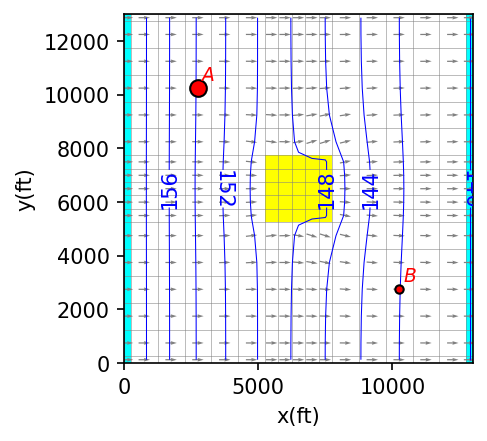

In [6]:
fig=plt.figure(figsize=(3, 4),dpi=150)              
ax=fig.add_subplot(111,aspect="equal")  ;mm=flopy.plot.PlotMapView(gwf,ax=ax) ;mm.plot_bc("CHD", color="cyan") ;mm.plot_inactive(color_noflow="yellow") ;mm.plot_grid(lw=0.25)
cv=mm.contour_array(head,levels=np.arange(140, 160  , 2),linewidths=0.5,linestyles="-",colors="blue"  ,masked_values=(0, 1e30, -1e30))    ; plt.clabel(cv,levels=np.arange(140,160,4),fmt="%1.0f")
ax.plot(p1[0], p1[1], marker="o", mfc="red",mec="black", ms=8) ; ax.plot(p2[0], p2[1] ,marker="o", mfc="red", mec="black", ms=4)          ; ax.set_xlabel("x(ft)") ; ax.set_ylabel("y(ft)")
styles.add_text(ax,"A",x=p1[0] + 150,y=p1[1] + 150 ,transform=False,bold=False,color="red",ha="left" ,va="bottom")    
styles.add_text(ax,"B",x=p2[0] + 150,y=p2[1] + 150 ,transform=False,bold=False,color="red",ha="left" ,va="bottom")   ; mm.plot_vector(qx, qy, normalize=True, color="0.5") ; plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

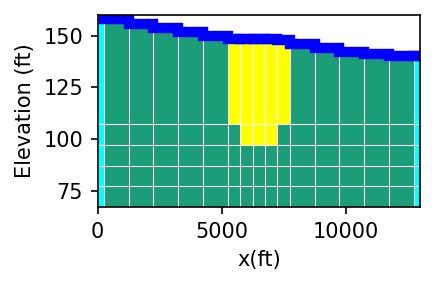

In [7]:
from flopy.utils.postprocessing import get_water_table  ; ALL = HOBJ.get_alldata()[0] ; wt = get_water_table(ALL) 
fig, ax = plt.subplots(1,1, figsize=(3, 2), dpi=150, tight_layout=True)  # ___________________________________________________________________________________________________ PLOT
XS = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": 8})  ; XS.plot_array(np.ones(shape3d), head=head, cmap="Dark2")  ; ax.set_xlabel("x(ft)") ; ax.set_ylim(67, 160) 
ax.set_ylabel("Elevation (ft)")                                ; XS.plot_bc("CHD", color="cyan", head=head) ; XS.plot_ibound(color_noflow="yellow", head=head)    
XS.plot_grid(lw=0.5, color="white")                            ; XS.plot_surface(wt, masked_values=[1e30], color="blue", lw=5)  ; plt.show

,Lake stage,pt A,pt B
totim,,,
16.013718,110.304133,115.965639,115.907172
32.347710,110.569356,117.112806,116.895995
49.008382,110.848627,118.469520,117.975006
66.002267,111.144677,120.030092,119.139682
83.336030,111.459627,121.762977,120.377045


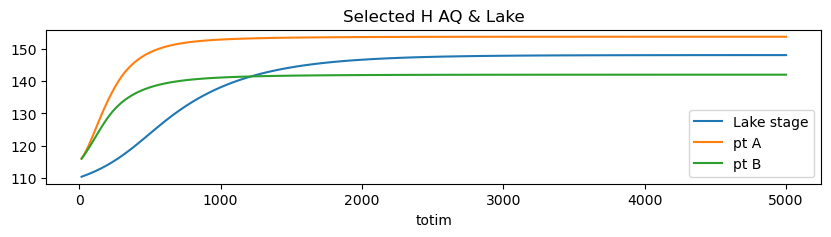

In [8]:
sim = flopy.mf6.MFSimulation.load(sim_ws = T14b , exe_name=exe_name, verbosity_level=0)           ; gwf = sim.get_model(ID)
LAK_R = gwf.lak.output.obs().data        ; GWF_R=gwf.obs[0].output.obs().data        ; df1=pd.DataFrame(LAK_R) ;df2=pd.DataFrame(GWF_R)  
df3 = df2.drop('totim', axis=1)                ; df = pd.concat([df1[:], df3[:]], axis=1)        ; df.set_index('totim', inplace=True, drop=True) 
df.columns = ['Lake stage', 'pt A', 'pt B']    ; ax = df.plot(use_index=True, y= list(df) , kind="line", rot=0, figsize=(10,2), title='Selected H AQ & Lake')   ; df.head()

In [13]:
ab=pd.DataFrame(LAK_C) ;ab =ab .rename(columns=lambda x :'a'+str(x))  ;ab2=ab['a2'];ab3=ab2.tolist()                 ; np.savetxt(T14 / "08_LAK_C_n.csv", ab3, delimiter=",")  
ab4=pd.DataFrame(ab3)  ;ab5=ab4.rename(columns=lambda x :'b'+str(x))  ;DF=pd.concat([ab[:],ab5[:]], axis=1)  ; DF.to_csv (T14 / "09_LAK_C.csv") ;DF.head(3) 

,a0,a1,a2,a3,a4,a5,a6,a7,a8,b0,b1,b2
0,0,0,"(0, 5, 6)",horizontal,0.1,107.0,500.0,500.0,500.0,0,5,6
1,0,1,"(0, 6, 5)",horizontal,0.1,107.0,500.0,500.0,500.0,0,6,5
2,0,2,"(1, 6, 6)",vertical,0.1,0.0,0.0,0.0,0.0,1,6,6
